# Quantum Kernel Machine Learning - Tutorial
## Quantum Kernel Clustering
This tutorial is based on a paper by Suzuki et. al., which itself is a study of the pioneering paper Supervised learning with quantum-enhanced feature spaces by Havlíček et.al. [1,2]. Suzuki et. al in their paper, study a two qubit classifier. The input data points are mapped to a unitary operator,
![image.png](attachment:image.png)
The input data is mapped to a unitary operator. U(x) is the unitary gate used to form the quantum circuit.The encoding functions are given as
![image-2.png](attachment:image-2.png)
Encoding functions that transform the input data points to a higher dimensional feature space from Suzuki et. al. are
![image-3.png](attachment:image-3.png)

### Code

In [1]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

In [2]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Callable, List, Union
from functools import reduce

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)


In [3]:
from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.datasets import ad_hoc_data

seed = 12345
algorithm_globals.random_seed = seed
adhoc_dimension = 2

adhoc_feature_map = ZZFeatureMap(feature_dimension=adhoc_dimension,


## Encoding functions

In [4]:
def data_map_eq8(x: np.ndarray) -> float:
    """
    Define a function map from R^n to R.

    Args:
        x: data

    Returns:
        float: the mapped value
    """
    coeff = x[0] if len(x) == 1 else reduce(lambda m, n: np.pi*(m * n), x)
    return coeff

def data_map_eq9(x: np.ndarray) -> float:
    coeff = x[0] if len(x) == 1 else reduce(lambda m, n: (np.pi/2)*(m * n), 1 - x)
    return coeff

def data_map_eq10(x: np.ndarray) -> float:
    coeff = x[0] if len(x) == 1 else reduce(lambda m, n: np.pi*np.exp(((m - n)*(m - n))/8), x)
    return coeff

def data_map_eq11(x: np.ndarray) -> float:
    coeff = x[0] if len(x) == 1 else reduce(lambda m, n: (np.pi/3)*(m * n), 1/(np.cos(x)))
    return coeff

def data_map_eq12(x: np.ndarray) -> float:
    coeff = x[0] if len(x) == 1 else reduce(lambda m, n: np.pi*(m * n), np.cos(x))
    return coeff

## Quantum Kernels

In [5]:
qfm_default = PauliFeatureMap(feature_dimension=2, 
                                    paulis = ['ZI','IZ','ZZ'],
                                 reps=2, entanglement='full')
qfm_eq8 = PauliFeatureMap(feature_dimension=2, 
                                    paulis = ['ZI','IZ','ZZ'],
                                 reps=2, entanglement='full', data_map_func=data_map_eq8)
qfm_eq9 = PauliFeatureMap(feature_dimension=2, 
                                    paulis = ['ZI','IZ','ZZ'],
                                 reps=2, entanglement='full', data_map_func=data_map_eq9)
qfm_eq10 = PauliFeatureMap(feature_dimension=2, 
                                    paulis = ['ZI','IZ','ZZ'],
                                 reps=2, entanglement='full', data_map_func=data_map_eq10)
qfm_eq11 = PauliFeatureMap(feature_dimension=2, 
                                    paulis = ['ZI','IZ','ZZ'],
                                 reps=2, entanglement='full', data_map_func=data_map_eq11)
qfm_eq12 = PauliFeatureMap(feature_dimension=2, 
                                    paulis = ['ZI','IZ','ZZ'],
                                 reps=2, entanglement='full', data_map_func=data_map_eq12)

qcomp_backend = QuantumInstance(BasicAer.get_backend('qasm_simulator'), shots=1024,
                                seed_simulator=seed, seed_transpiler=seed)

qkern_default = QuantumKernel(feature_map=qfm_default, quantum_instance=qcomp_backend)
qkern_eq8 = QuantumKernel(feature_map=qfm_eq8, quantum_instance=qcomp_backend)
qkern_eq9 = QuantumKernel(feature_map=qfm_eq9, quantum_instance=qcomp_backend)
qkern_eq10 = QuantumKernel(feature_map=qfm_eq10, quantum_instance=qcomp_backend)
qkern_eq11 = QuantumKernel(feature_map=qfm_eq11, quantum_instance=qcomp_backend)
qkern_eq12 = QuantumKernel(feature_map=qfm_eq12, quantum_instance=qcomp_backend)


## Clustering Experiments

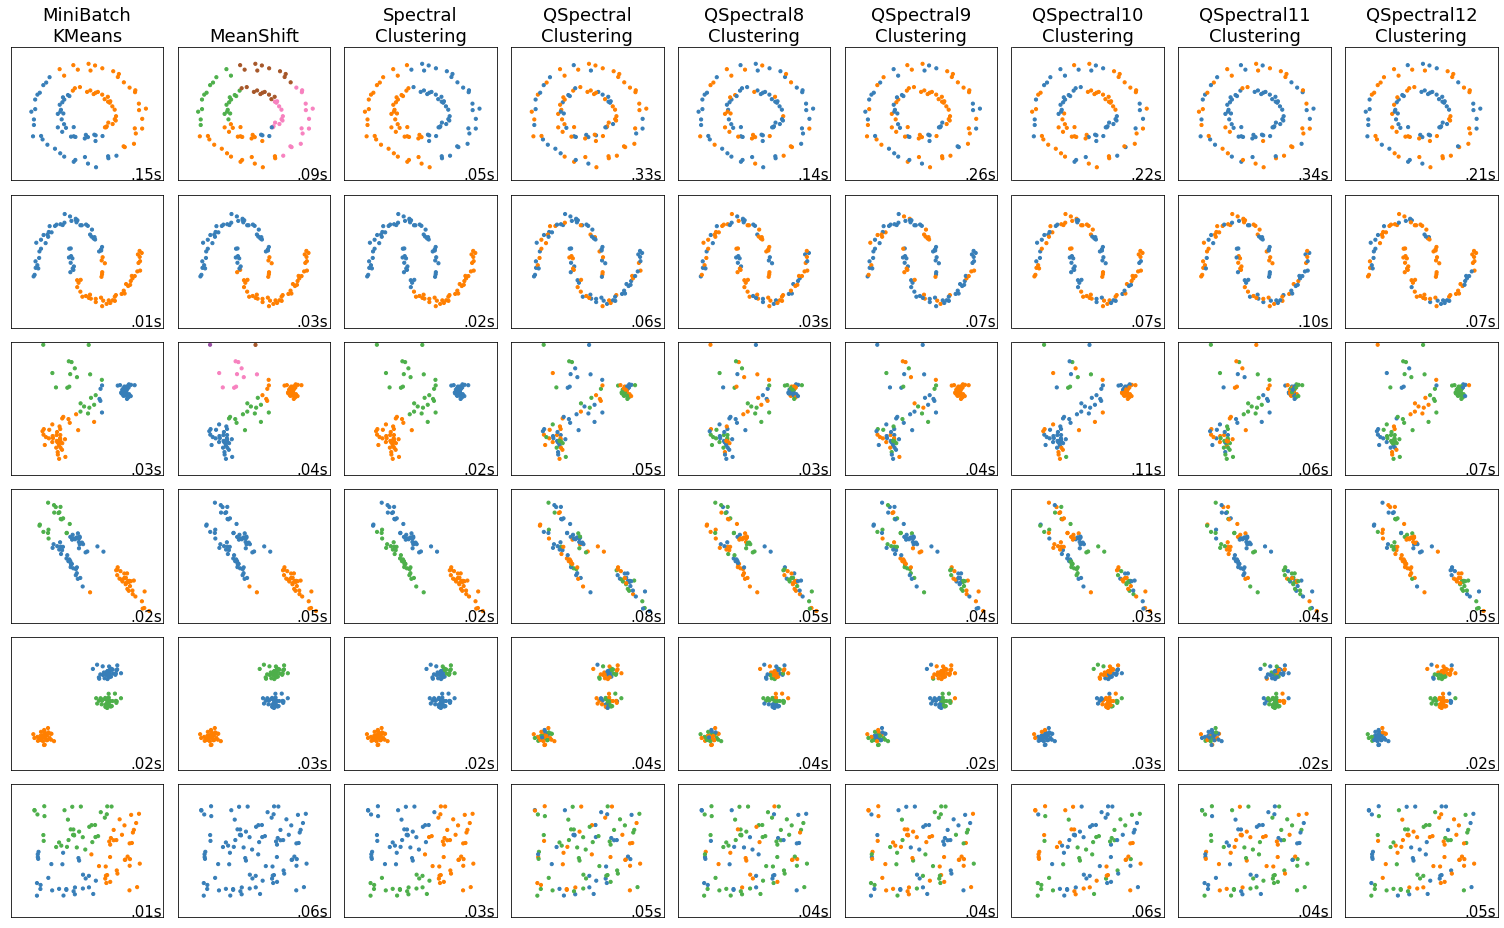

In [6]:
# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 100
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
#plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.95, wspace=.05,
#                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    (aniso, {'eps': .15, 'n_neighbors': 2,
             'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)
    
    # Kernel matrix for quantum
    #adhoc_matrix = adhoc_kernel.evaluate(x_vec=X)
    qkern_default_matrix = qkern_default.evaluate(x_vec=X)
    qkern_eq8_matrix = qkern_eq8.evaluate(x_vec=X)
    qkern_eq9_matrix = qkern_eq9.evaluate(x_vec=X)
    qkern_eq10_matrix = qkern_eq10.evaluate(x_vec=X)
    qkern_eq11_matrix = qkern_eq11.evaluate(x_vec=X)
    qkern_eq12_matrix = qkern_eq12.evaluate(x_vec=X)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    qspectral =  cluster.SpectralClustering(n_clusters=params['n_clusters'], affinity="precomputed")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    optics = cluster.OPTICS(min_samples=params['min_samples'],
                            xi=params['xi'],
                            min_cluster_size=params['min_cluster_size'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')


    clustering_algorithms = (
        ('MiniBatch\nKMeans', two_means, X),
        ('MeanShift', ms, X),
        ('Spectral\nClustering', spectral, X),
        ('QSpectral\nClustering', qspectral, qkern_default_matrix),
        ('QSpectral8\nClustering', qspectral, qkern_eq8_matrix),
        ('QSpectral9\nClustering', qspectral, qkern_eq9_matrix),
        ('QSpectral10\nClustering', qspectral, qkern_eq10_matrix),
        ('QSpectral11\nClustering', qspectral, qkern_eq11_matrix),
        ('QSpectral12\nClustering', qspectral, qkern_eq12_matrix)
    )

    for name, algorithm, mtx in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            #if name in ['MiniBatch\nKMeans', 'MeanShift', 'Spectral\nClustering']:
            #    algorithm.fit(X)
                #print(f'non quantum')
            #else:
            algorithm.fit(mtx)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(int)
            #print(f'Using labels')
        else:
            y_pred = algorithm.predict(X)
            print(f'Using predict')

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1
        
plt.tight_layout()
plt.show()